# Introduction to Poisson Regression for Count Data - SOLUTIONS

**Tutorial 01 Solutions - Count Models Series**

---

## Overview

This notebook contains:
1. **All content from the main tutorial**
2. **Detailed solutions to exercises**
3. **Additional exercises with solutions**
4. **Alternative approaches and interpretations**
5. **Common mistakes and how to avoid them**
6. **Pedagogical notes explaining WHY methods work**

---

## Setup and Data Loading

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# PanelBox imports
from panelbox.models.count import PooledPoisson
import statsmodels.api as sm

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
np.random.seed(42)

# Paths
DATA_PATH = Path('../data')
OUTPUT_PATH = Path('../outputs')
FIGURES_PATH = OUTPUT_PATH / 'figures' / '01_poisson_solutions'
TABLES_PATH = OUTPUT_PATH / 'tables' / '01_poisson_solutions'

# Create output directories
FIGURES_PATH.mkdir(parents=True, exist_ok=True)
TABLES_PATH.mkdir(parents=True, exist_ok=True)

print("Setup complete!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Setup complete!
NumPy version: 2.3.5
Pandas version: 2.3.3


In [2]:
# Load data
df = pd.read_csv(DATA_PATH / 'healthcare_visits.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
display(df.head(10))

print("\nDescriptive Statistics:")
display(df.describe())

Dataset Shape: (2000, 6)

First few rows:


,individual_id,visits,age,income,insurance,chronic
0,1,4,53,26.9745,1,0
1,2,4,42,37.0878,1,0
2,3,5,56,25.1422,0,0
3,4,9,72,33.6234,1,0
4,5,8,40,12.9855,1,0
5,6,1,40,45.9694,1,0
6,7,5,73,40.4766,1,0
7,8,19,58,24.7728,1,1
8,9,2,36,60.0722,1,0
9,10,4,54,70.9902,1,1



Descriptive Statistics:


,individual_id,visits,age,income,insurance,chronic
count,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000
mean,1000.5000,6.2930,45.6990,47.7515,0.7765,0.2850
std,577.4946,4.4439,16.6459,29.1495,0.4167,0.4515
min,1.0000,0.0000,18.0000,10.0000,0.0000,0.0000
25%,500.7500,3.0000,33.0000,26.4307,1.0000,0.0000
50%,1000.5000,5.0000,45.0000,40.4460,1.0000,0.0000
75%,1500.2500,8.0000,57.0000,60.2996,1.0000,1.0000
max,2000.0000,25.0000,85.0000,150.0000,1.0000,1.0000


## Baseline Model Estimation

First, let's estimate the baseline model from the main tutorial:

In [3]:
# Baseline specification
y = df['visits']
X_baseline = df[['age', 'income', 'insurance', 'chronic']]

# Estimate baseline Poisson model
poisson_baseline = PooledPoisson(endog=y, exog=sm.add_constant(X_baseline))
results_baseline = poisson_baseline.fit(se_type='robust')

# Compute fitted values
fitted_baseline = poisson_baseline.predict(type='response')

print("BASELINE POISSON MODEL")
print("="*80)
print(results_baseline.summary())

BASELINE POISSON MODEL

Model Results
Number of Obs: 2000
Number of Parameters: 5

Parameter Estimates:
-------------------
  Param 0: 0.5168 (SE: 0.0385, t: 13.42, p: 0.0000)
  Param 1: 0.0153 (SE: 0.0005, t: 29.33, p: 0.0000)
  Param 2: -0.0022 (SE: 0.0003, t: -6.72, p: 0.0000)
  Param 3: 0.4673 (SE: 0.0249, t: 18.74, p: 0.0000)
  Param 4: 0.8197 (SE: 0.0179, t: 45.92, p: 0.0000)



---

# EXERCISE SOLUTIONS

---

## Exercise 1: Nonlinear Age Effects

**Question**: Add an age-squared term to test for nonlinear effects of age on healthcare visits.

### Solution

In [4]:
print("="*80)
print("EXERCISE 1: NONLINEAR AGE EFFECTS")
print("="*80)

# Create age-squared variable
df['age_squared'] = df['age'] ** 2

# Estimate model with age-squared
X_nonlinear = df[['age', 'age_squared', 'income', 'insurance', 'chronic']]

poisson_nonlinear = PooledPoisson(endog=y, exog=sm.add_constant(X_nonlinear))
results_nonlinear = poisson_nonlinear.fit(se_type='robust')

print("\nPOISSON MODEL WITH AGE-SQUARED")
print(results_nonlinear.summary())

EXERCISE 1: NONLINEAR AGE EFFECTS



POISSON MODEL WITH AGE-SQUARED

Model Results
Number of Obs: 2000
Number of Parameters: 6

Parameter Estimates:
-------------------
  Param 0: 0.5261 (SE: 0.0724, t: 7.26, p: 0.0000)
  Param 1: 0.0141 (SE: 0.0027, t: 5.17, p: 0.0000)
  Param 2: 0.0000 (SE: 0.0000, t: 0.63, p: 0.5258)
  Param 3: -0.0020 (SE: 0.0003, t: -6.26, p: 0.0000)
  Param 4: 0.4449 (SE: 0.0249, t: 17.84, p: 0.0000)
  Param 5: 0.8181 (SE: 0.0180, t: 45.46, p: 0.0000)



### Interpretation

The quadratic specification allows us to test whether the effect of age on visits is:
- **Linear**: If age² coefficient ≈ 0
- **Accelerating**: If age² coefficient > 0 (visits increase faster at older ages)
- **Decelerating**: If age² coefficient < 0 (visits increase slower at older ages)

In [5]:
# Test significance of age-squared
# With const at index 0: params[0]=const, params[1]=age, params[2]=age_squared
beta_age = results_nonlinear.params[1]
beta_age2 = results_nonlinear.params[2]
pval_age2 = results_nonlinear.pvalues[2]

print("\nINTERPRETATION OF NONLINEAR AGE EFFECTS")
print("="*80)
print(f"Age coefficient: {beta_age:.6f}")
print(f"Age² coefficient: {beta_age2:.6f}")
print(f"Age² p-value: {pval_age2:.6f}")

if pval_age2 < 0.05:
    if beta_age2 > 0:
        print("\n→ ACCELERATING effect: Visits increase faster at older ages")
    else:
        print("\n→ DECELERATING effect: Visits increase slower at older ages")
else:
    print("\n→ NO EVIDENCE of nonlinearity; linear age effect is adequate")

# Calculate turning point if significant quadratic
if pval_age2 < 0.05 and beta_age2 != 0:
    turning_point = -beta_age / (2 * beta_age2)
    print(f"\nTurning point (if within data range): {turning_point:.2f} years")
    print(f"Data age range: {df['age'].min():.0f} - {df['age'].max():.0f} years")


INTERPRETATION OF NONLINEAR AGE EFFECTS
Age coefficient: 0.014137
Age² coefficient: 0.000017
Age² p-value: 0.525803

→ NO EVIDENCE of nonlinearity; linear age effect is adequate


### Visualize Nonlinear Effect

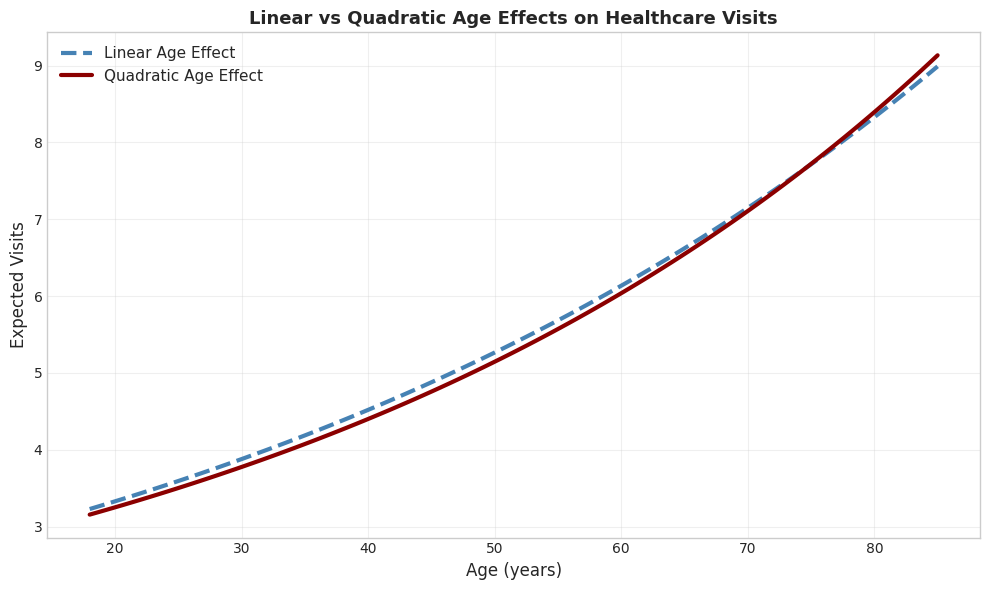


Visualization shows the difference between linear and quadratic specifications


In [6]:
# Compare linear vs quadratic predictions
age_range = np.linspace(df['age'].min(), df['age'].max(), 100)

# Create prediction data
pred_data = pd.DataFrame({
    'age': age_range,
    'age_squared': age_range ** 2,
    'income': df['income'].median(),
    'insurance': 1,
    'chronic': 0
})

# Linear model predictions (with const prepended)
X_pred_linear_arr = np.column_stack([np.ones(100), pred_data[['age', 'income', 'insurance', 'chronic']].values])
pred_linear = np.exp(X_pred_linear_arr @ results_baseline.params)

# Quadratic model predictions (with const prepended)
X_pred_quad_arr = np.column_stack([np.ones(100), pred_data[['age', 'age_squared', 'income', 'insurance', 'chronic']].values])
pred_quad = np.exp(X_pred_quad_arr @ results_nonlinear.params)

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(age_range, pred_linear, linewidth=3, color='steelblue', 
        label='Linear Age Effect', linestyle='--')
ax.plot(age_range, pred_quad, linewidth=3, color='darkred',
        label='Quadratic Age Effect')

ax.set_xlabel('Age (years)', fontsize=12)
ax.set_ylabel('Expected Visits', fontsize=12)
ax.set_title('Linear vs Quadratic Age Effects on Healthcare Visits', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'ex1_linear_vs_quadratic.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization shows the difference between linear and quadratic specifications")

### Pedagogical Note: Why Test for Nonlinearity?

**Common Mistake**: Assuming all relationships are linear.

**Why test nonlinearity?**
1. **Biological plausibility**: Healthcare needs may accelerate with age
2. **Model misspecification**: Linear assumption may be too restrictive
3. **Better predictions**: Capturing curvature improves fit

**How to decide**:
- Use **likelihood ratio test** (compare log-likelihoods)
- Use **AIC/BIC** (penalized fit measures)
- Consider **theory** and **domain knowledge**

In [7]:
# Formal model comparison
ll_linear = poisson_baseline._log_likelihood(results_baseline.params)
ll_quadratic = poisson_nonlinear._log_likelihood(results_nonlinear.params)

# Likelihood ratio test
lr_stat = 2 * (ll_quadratic - ll_linear)
lr_pval = 1 - stats.chi2.cdf(lr_stat, df=1)  # 1 additional parameter

# AIC comparison
n = len(y)
k_linear = len(results_baseline.params)
k_quad = len(results_nonlinear.params)

aic_linear = -2 * ll_linear + 2 * k_linear
aic_quad = -2 * ll_quadratic + 2 * k_quad

print("\nMODEL COMPARISON: LINEAR VS QUADRATIC")
print("="*80)
print(f"{'Criterion':<20} {'Linear':<15} {'Quadratic':<15} {'Preferred'}")
print("-"*80)
print(f"{'Log-Likelihood':<20} {ll_linear:<15.4f} {ll_quadratic:<15.4f} {'Quadratic' if ll_quadratic > ll_linear else 'Linear'}")
print(f"{'AIC':<20} {aic_linear:<15.4f} {aic_quad:<15.4f} {'Quadratic' if aic_quad < aic_linear else 'Linear'}")
print(f"\nLikelihood Ratio Test: LR = {lr_stat:.4f}, p-value = {lr_pval:.6f}")

if lr_pval < 0.05:
    print("→ Quadratic specification is SIGNIFICANTLY better")
else:
    print("→ No significant improvement from quadratic term")
print("="*80)


MODEL COMPARISON: LINEAR VS QUADRATIC
Criterion            Linear          Quadratic       Preferred
--------------------------------------------------------------------------------
Log-Likelihood       -4665.6458      -4668.2509      Linear
AIC                  9341.2916       9348.5018       Linear

Likelihood Ratio Test: LR = -5.2103, p-value = 1.000000
→ No significant improvement from quadratic term


---

## Exercise 2: Interaction Effects

**Question**: Include an interaction between insurance and chronic condition. Does the effect of insurance differ for those with chronic conditions?

### Solution

In [8]:
print("="*80)
print("EXERCISE 2: INSURANCE × CHRONIC CONDITION INTERACTION")
print("="*80)

# Create interaction term
df['insurance_x_chronic'] = df['insurance'] * df['chronic']

# Estimate model with interaction
X_interaction = df[['age', 'income', 'insurance', 'chronic', 'insurance_x_chronic']]

poisson_interaction = PooledPoisson(endog=y, exog=sm.add_constant(X_interaction))
results_interaction = poisson_interaction.fit(se_type='robust')

print("\nPOISSON MODEL WITH INSURANCE × CHRONIC INTERACTION")
print(results_interaction.summary())

EXERCISE 2: INSURANCE × CHRONIC CONDITION INTERACTION

POISSON MODEL WITH INSURANCE × CHRONIC INTERACTION

Model Results
Number of Obs: 2000
Number of Parameters: 6

Parameter Estimates:
-------------------
  Param 0: 0.5291 (SE: 0.0430, t: 12.32, p: 0.0000)
  Param 1: 0.0153 (SE: 0.0005, t: 29.33, p: 0.0000)
  Param 2: -0.0021 (SE: 0.0003, t: -6.70, p: 0.0000)
  Param 3: 0.4519 (SE: 0.0346, t: 13.06, p: 0.0000)
  Param 4: 0.7926 (SE: 0.0460, t: 17.22, p: 0.0000)
  Param 5: 0.0319 (SE: 0.0499, t: 0.64, p: 0.5224)



### Interpretation of Interaction Effects

With interaction terms, interpretation becomes more nuanced:

$$\log(E[visits]) = \beta_0 + \beta_1 insurance + \beta_2 chronic + \beta_3 (insurance \times chronic) + ...$$

**Effect of insurance**:
- For non-chronic: $\beta_1$
- For chronic: $\beta_1 + \beta_3$

**Effect of chronic condition**:
- Without insurance: $\beta_2$
- With insurance: $\beta_2 + \beta_3$

In [9]:
# Extract interaction results
# With const at index 0: params[0]=const, params[1]=age, params[2]=income,
# params[3]=insurance, params[4]=chronic, params[5]=insurance_x_chronic
beta_ins = results_interaction.params[3]
beta_chronic = results_interaction.params[4]
beta_interaction = results_interaction.params[5]

# Calculate effects for each group
print("\nINTERPRETATION OF INTERACTION EFFECTS")
print("="*80)

# Effect of insurance
effect_ins_nonchronic = np.exp(beta_ins) - 1
effect_ins_chronic = np.exp(beta_ins + beta_interaction) - 1

print("\nEFFECT OF INSURANCE:")
print(f"  Among non-chronic: {effect_ins_nonchronic*100:+.2f}%")
print(f"  Among chronic: {effect_ins_chronic*100:+.2f}%")
print(f"  Difference: {(effect_ins_chronic - effect_ins_nonchronic)*100:.2f} percentage points")

# Effect of chronic condition
effect_chronic_noins = np.exp(beta_chronic) - 1
effect_chronic_ins = np.exp(beta_chronic + beta_interaction) - 1

print("\nEFFECT OF CHRONIC CONDITION:")
print(f"  Without insurance: {effect_chronic_noins*100:+.2f}%")
print(f"  With insurance: {effect_chronic_ins*100:+.2f}%")
print(f"  Difference: {(effect_chronic_ins - effect_chronic_noins)*100:.2f} percentage points")

# Test interaction significance
pval_interaction = results_interaction.pvalues[5]
print(f"\nInteraction coefficient: {beta_interaction:.6f}")
print(f"Interaction p-value: {pval_interaction:.6f}")

if pval_interaction < 0.05:
    if beta_interaction > 0:
        print("\n→ POSITIVE SYNERGY: Insurance effect is STRONGER for chronic patients")
    else:
        print("\n→ NEGATIVE INTERACTION: Insurance effect is WEAKER for chronic patients")
else:
    print("\n→ NO SIGNIFICANT INTERACTION: Insurance effect similar across groups")
print("="*80)


INTERPRETATION OF INTERACTION EFFECTS

EFFECT OF INSURANCE:
  Among non-chronic: +57.13%
  Among chronic: +62.23%
  Difference: 5.10 percentage points

EFFECT OF CHRONIC CONDITION:
  Without insurance: +120.92%
  With insurance: +128.09%
  Difference: 7.17 percentage points

Interaction coefficient: 0.031942
Interaction p-value: 0.522423

→ NO SIGNIFICANT INTERACTION: Insurance effect similar across groups


### Visualize Interaction Effects

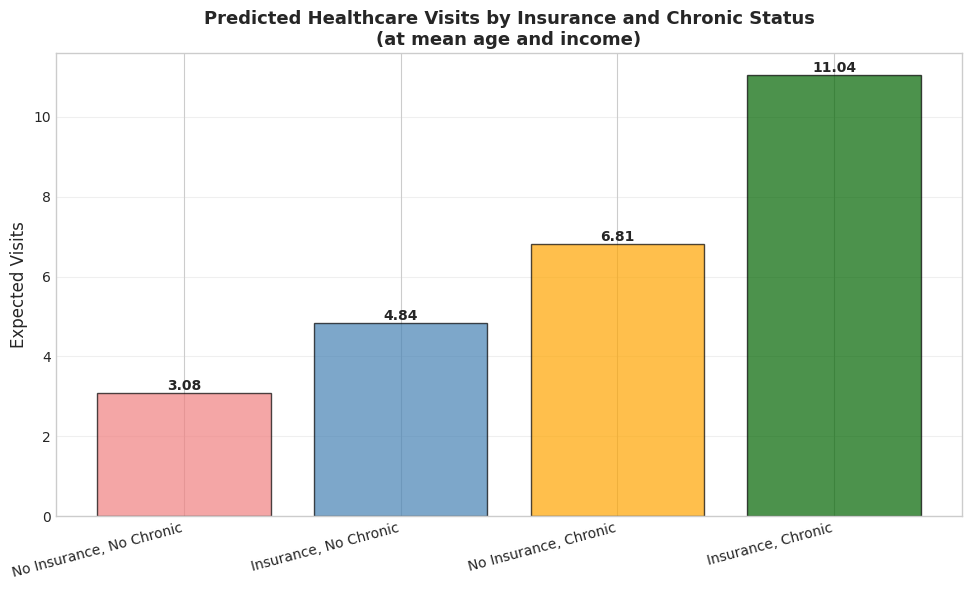


The visualization shows how insurance and chronic condition interact
to affect expected healthcare visits.


In [10]:
# Create prediction data for all four combinations
combinations = [
    (0, 0, 'No Insurance, No Chronic'),
    (1, 0, 'Insurance, No Chronic'),
    (0, 1, 'No Insurance, Chronic'),
    (1, 1, 'Insurance, Chronic')
]

pred_results = []

for ins, chronic, label in combinations:
    # Build X matrix with const prepended
    # Order: const, age, income, insurance, chronic, insurance_x_chronic
    X_pred_arr = np.array([1, df['age'].mean(), df['income'].mean(), ins, chronic, ins * chronic])
    
    pred = np.exp(X_pred_arr @ results_interaction.params)
    pred_results.append((label, pred))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

labels = [x[0] for x in pred_results]
values = [x[1] for x in pred_results]
colors = ['lightcoral', 'steelblue', 'orange', 'darkgreen']

bars = ax.bar(range(len(labels)), values, color=colors, edgecolor='black', alpha=0.7)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=15, ha='right')
ax.set_ylabel('Expected Visits', fontsize=12)
ax.set_title('Predicted Healthcare Visits by Insurance and Chronic Status\n(at mean age and income)',
             fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'ex2_interaction_effects.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nThe visualization shows how insurance and chronic condition interact")
print("to affect expected healthcare visits.")

### Pedagogical Note: Interpreting Interactions in Count Models

**Common Mistake**: Interpreting interaction coefficients directly as effects.

**Correct Approach**:
1. **Calculate predicted values** for all combinations
2. **Compare differences** across groups
3. **Visualize** the interaction pattern

**Why interactions matter**:
- **Heterogeneous effects**: Treatment effects vary by subgroup
- **Policy targeting**: Identify who benefits most
- **Mechanism understanding**: How factors combine

**Caution**: In exponential models (like Poisson), interactions are on the **log scale**, not the level scale!

---

## Exercise 3: Model Selection with AIC/BIC

**Question**: Compare all model specifications using AIC and BIC. Which model is preferred?

### Solution

In [11]:
print("="*80)
print("EXERCISE 3: MODEL SELECTION USING AIC AND BIC")
print("="*80)

# Collect all models (model objects and results)
model_objects = {
    'Baseline': (poisson_baseline, results_baseline),
    'Quadratic Age': (poisson_nonlinear, results_nonlinear),
    'With Interaction': (poisson_interaction, results_interaction)
}

# Calculate AIC and BIC for each model
comparison_results = []

n = len(y)

for name, (model_obj, model_res) in model_objects.items():
    ll = model_obj._log_likelihood(model_res.params)
    k = len(model_res.params)
    
    aic = -2 * ll + 2 * k
    bic = -2 * ll + k * np.log(n)
    
    comparison_results.append({
        'Model': name,
        'Parameters': k,
        'Log-Likelihood': ll,
        'AIC': aic,
        'BIC': bic
    })

comparison_df = pd.DataFrame(comparison_results)

# Identify best models
best_aic = comparison_df.loc[comparison_df['AIC'].idxmin(), 'Model']
best_bic = comparison_df.loc[comparison_df['BIC'].idxmin(), 'Model']

print("\nMODEL COMPARISON TABLE")
print("="*100)
display(comparison_df)

print("\nMODEL SELECTION RESULTS")
print("="*80)
print(f"Best model by AIC: {best_aic}")
print(f"Best model by BIC: {best_bic}")

if best_aic == best_bic:
    print(f"\n→ Both criteria agree: {best_aic} is preferred")
else:
    print(f"\n→ Criteria disagree:")
    print(f"  AIC prefers: {best_aic} (favors better fit)")
    print(f"  BIC prefers: {best_bic} (favors parsimony)")

# Save comparison table
comparison_df.to_csv(TABLES_PATH / 'ex3_model_comparison.csv', index=False)
print("\n✓ Comparison table saved")
print("="*80)

EXERCISE 3: MODEL SELECTION USING AIC AND BIC

MODEL COMPARISON TABLE


,Model,Parameters,Log-Likelihood,AIC,BIC
0,Baseline,5,-4665.6458,9341.2916,9369.2961
1,Quadratic Age,6,-4668.2509,9348.5018,9382.1073
2,With Interaction,6,-4665.4412,9342.8824,9376.4878



MODEL SELECTION RESULTS
Best model by AIC: Baseline
Best model by BIC: Baseline

→ Both criteria agree: Baseline is preferred

✓ Comparison table saved


### Pedagogical Note: AIC vs BIC

**AIC (Akaike Information Criterion)**:
$$AIC = -2\ln(L) + 2k$$
- Penalizes complexity less
- Favors **predictive accuracy**
- Asymptotically efficient

**BIC (Bayesian Information Criterion)**:
$$BIC = -2\ln(L) + k\ln(n)$$
- Penalizes complexity more (for $n > 8$)
- Favors **parsimony**
- Consistent (selects true model as $n \to \infty$)

**When they disagree**:
- AIC selects more complex model → better predictions
- BIC selects simpler model → easier interpretation
- Consider **purpose**: prediction vs explanation

**Rule of thumb**: Difference > 10 is "strong" evidence

In [12]:
# Calculate AIC/BIC differences
min_aic = comparison_df['AIC'].min()
min_bic = comparison_df['BIC'].min()

comparison_df['Delta_AIC'] = comparison_df['AIC'] - min_aic
comparison_df['Delta_BIC'] = comparison_df['BIC'] - min_bic

print("\nMODEL SELECTION STRENGTH (Δ measures)")
print("="*100)
print("\nΔAIC (difference from best): < 2 (similar), 4-7 (considerably less), > 10 (essentially none)")
print("ΔBIC (difference from best): Similar interpretation\n")
display(comparison_df[['Model', 'Delta_AIC', 'Delta_BIC']])

# Interpretation
for idx, row in comparison_df.iterrows():
    if row['Delta_AIC'] == 0:
        print(f"\n{row['Model']}: BEST by AIC")
    elif row['Delta_AIC'] < 2:
        print(f"\n{row['Model']}: Substantial support (ΔAIC = {row['Delta_AIC']:.2f})")
    elif row['Delta_AIC'] < 7:
        print(f"\n{row['Model']}: Considerably less support (ΔAIC = {row['Delta_AIC']:.2f})")
    else:
        print(f"\n{row['Model']}: Essentially no support (ΔAIC = {row['Delta_AIC']:.2f})")


MODEL SELECTION STRENGTH (Δ measures)

ΔAIC (difference from best): < 2 (similar), 4-7 (considerably less), > 10 (essentially none)
ΔBIC (difference from best): Similar interpretation



,Model,Delta_AIC,Delta_BIC
0,Baseline,0.0000,0.0000
1,Quadratic Age,7.2103,12.8112
2,With Interaction,1.5908,7.1917



Baseline: BEST by AIC

Quadratic Age: Essentially no support (ΔAIC = 7.21)

With Interaction: Substantial support (ΔAIC = 1.59)


---

# ADDITIONAL EXERCISES

---

## Bonus Exercise 4: Predicted Probabilities

**Question**: Calculate the predicted probability of exactly 0, 1, 2, or 3 visits for a 50-year-old with median income, insurance, and no chronic condition.

### Solution

In [13]:
print("="*80)
print("BONUS EXERCISE 4: PREDICTED PROBABILITIES")
print("="*80)

# Define individual characteristics
# Build X with const prepended: [const, age, income, insurance, chronic]
X_individual_arr = np.array([1, 50, df['income'].median(), 1, 0])

# Predict lambda (rate parameter)
lambda_pred = np.exp(X_individual_arr @ results_baseline.params)

print(f"\nIndividual characteristics:")
print(f"  Age: 50 years")
print(f"  Income: ${df['income'].median():.2f}k")
print(f"  Insurance: Yes")
print(f"  Chronic condition: No")

print(f"\nPredicted rate (λ): {lambda_pred:.4f}")

# Calculate probabilities for different visit counts
visit_counts = [0, 1, 2, 3, 4, 5]
probabilities = [stats.poisson.pmf(k, lambda_pred) for k in visit_counts]

print("\nPREDICTED PROBABILITIES")
print("="*60)
print(f"{'Visits':<10} {'Probability':<15} {'Percentage'}")
print("-"*60)

for k, prob in zip(visit_counts, probabilities):
    print(f"{k:<10} {prob:<15.6f} {prob*100:>6.2f}%")

# Cumulative probabilities
print("\nCUMULATIVE PROBABILITIES")
print("="*60)
print(f"P(Visits ≤ 2) = {sum(probabilities[:3])*100:.2f}%")
print(f"P(Visits ≤ 5) = {sum(probabilities)*100:.2f}%")
print(f"P(Visits > 5) = {(1 - sum(probabilities))*100:.2f}%")
print("="*60)

BONUS EXERCISE 4: PREDICTED PROBABILITIES

Individual characteristics:
  Age: 50 years
  Income: $40.45k
  Insurance: Yes
  Chronic condition: No

Predicted rate (λ): 5.2655

PREDICTED PROBABILITIES
Visits     Probability     Percentage
------------------------------------------------------------
0          0.005167          0.52%
1          0.027206          2.72%
2          0.071627          7.16%
3          0.125716         12.57%
4          0.165490         16.55%
5          0.174277         17.43%

CUMULATIVE PROBABILITIES
P(Visits ≤ 2) = 10.40%
P(Visits ≤ 5) = 56.95%
P(Visits > 5) = 43.05%


### Visualize Probability Distribution

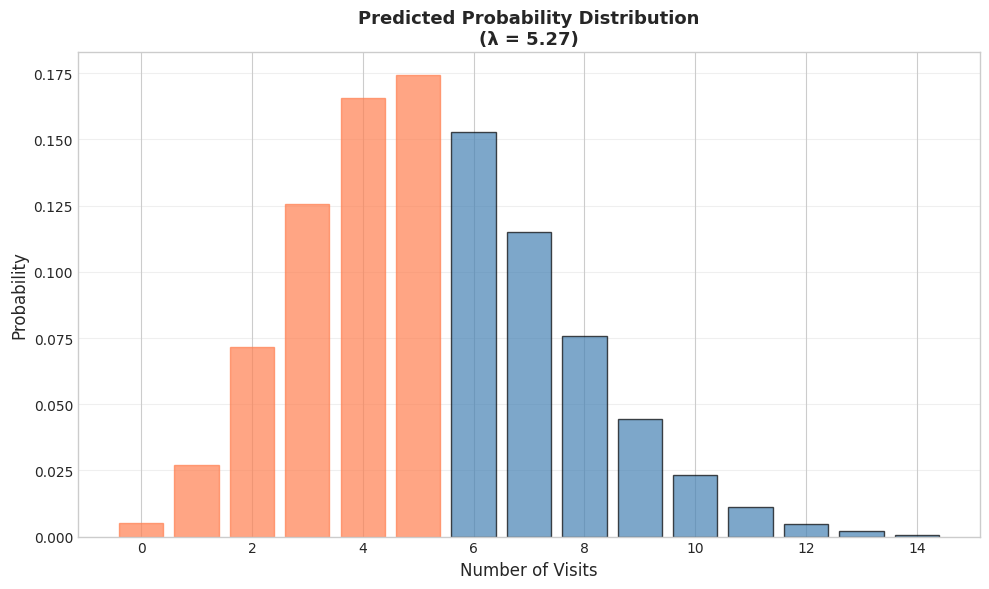


Pedagogical Note:
The Poisson distribution is fully characterized by λ (the rate parameter).
Higher λ → distribution shifts right and becomes more spread out.


In [14]:
# Extended range for visualization
visit_range = np.arange(0, 15)
probs_extended = [stats.poisson.pmf(k, lambda_pred) for k in visit_range]

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(visit_range, probs_extended, edgecolor='black', alpha=0.7, color='steelblue')

# Highlight specific probabilities
for i in range(6):
    bars[i].set_color('coral')

ax.set_xlabel('Number of Visits', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.set_title(f'Predicted Probability Distribution\n(λ = {lambda_pred:.2f})',
             fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'ex4_probability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPedagogical Note:")
print("The Poisson distribution is fully characterized by λ (the rate parameter).")
print("Higher λ → distribution shifts right and becomes more spread out.")

---

## Bonus Exercise 5: Marginal Effects

**Question**: Calculate the average marginal effect of income on healthcare visits.

### Solution

In [15]:
print("="*80)
print("BONUS EXERCISE 5: MARGINAL EFFECTS")
print("="*80)

# Get coefficient for income
# With const at index 0: params[0]=const, params[1]=age, params[2]=income
beta_income = results_baseline.params[2]

# Use fitted values computed earlier in cell-5
fitted_values = fitted_baseline

# Marginal effect = beta * lambda (for each individual)
me_income_individual = beta_income * fitted_values

# Average marginal effect
ame_income = me_income_individual.mean()

print("\nMARGINAL EFFECT OF INCOME")
print("="*80)
print(f"\nCoefficient (β): {beta_income:.6f}")
print(f"\nAverage Marginal Effect (AME): {ame_income:.6f}")
print(f"\nInterpretation:")
print(f"  On average, a $1,000 increase in income is associated with")
print(f"  {ame_income:.4f} additional healthcare visits.")

# Compare to semi-elasticity
pct_change = beta_income * 100
print(f"\nAlternative interpretation (semi-elasticity):")
print(f"  A $1,000 increase in income → {pct_change:.2f}% change in visits")

# Distribution of marginal effects
print(f"\nDistribution of individual marginal effects:")
print(f"  Mean: {me_income_individual.mean():.6f}")
print(f"  Std Dev: {me_income_individual.std():.6f}")
print(f"  Min: {me_income_individual.min():.6f}")
print(f"  Max: {me_income_individual.max():.6f}")
print("="*80)

BONUS EXERCISE 5: MARGINAL EFFECTS

MARGINAL EFFECT OF INCOME

Coefficient (β): -0.002151

Average Marginal Effect (AME): -0.013536

Interpretation:
  On average, a $1,000 increase in income is associated with
  -0.0135 additional healthcare visits.

Alternative interpretation (semi-elasticity):
  A $1,000 increase in income → -0.22% change in visits

Distribution of individual marginal effects:
  Mean: -0.013536
  Std Dev: 0.007502
  Min: -0.046440
  Max: -0.003439


### Pedagogical Note: Marginal Effects in Count Models

**Key Concept**: In Poisson regression, marginal effects are **heterogeneous** (vary across individuals).

For continuous variable $x_j$:
$$\frac{\partial E[y|X]}{\partial x_j} = \beta_j \cdot \lambda = \beta_j \cdot E[y|X]$$

**Why heterogeneous?**
- Marginal effect = $\beta_j \times \lambda_i$
- Different individuals have different $\lambda_i$
- Higher baseline → larger marginal effect

**Reporting**:
- **AME** (Average Marginal Effect): Most common
- **MER** (at means): Easier but less representative
- **Distribution**: Shows heterogeneity

See Tutorial 06 for comprehensive coverage!

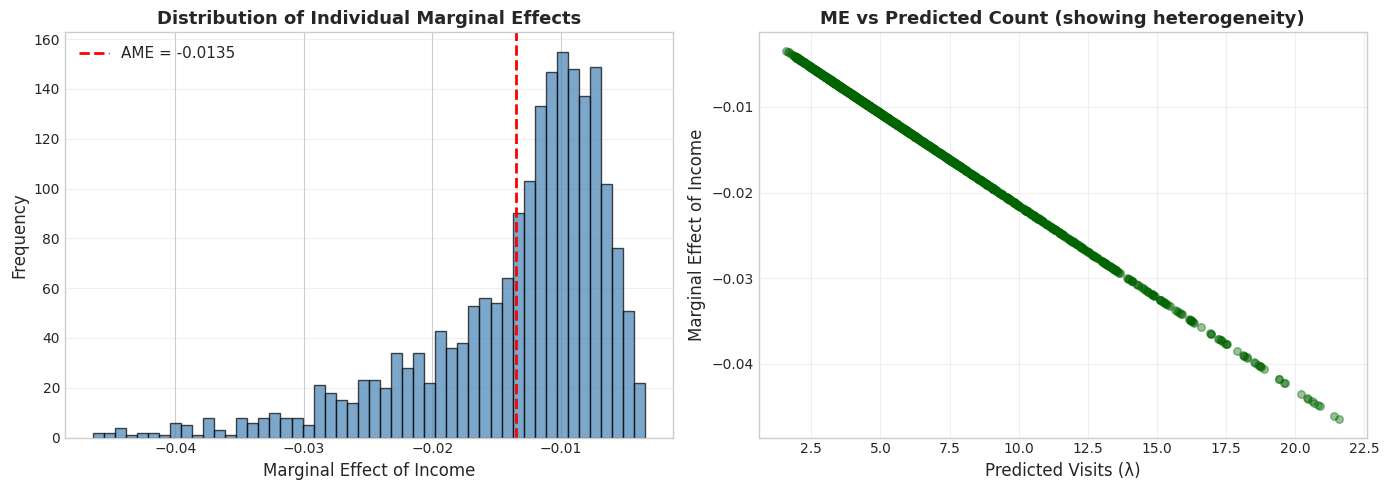


Note: Marginal effects are LARGER for individuals with higher predicted counts!


In [16]:
# Visualize heterogeneity in marginal effects
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of marginal effects
axes[0].hist(me_income_individual, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(ame_income, color='red', linestyle='--', linewidth=2,
                label=f'AME = {ame_income:.4f}')
axes[0].set_xlabel('Marginal Effect of Income', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Individual Marginal Effects', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Marginal effect vs fitted value
axes[1].scatter(fitted_values, me_income_individual, alpha=0.4, s=30, color='darkgreen')
axes[1].set_xlabel('Predicted Visits (λ)', fontsize=12)
axes[1].set_ylabel('Marginal Effect of Income', fontsize=12)
axes[1].set_title('ME vs Predicted Count (showing heterogeneity)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'ex5_marginal_effects.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nNote: Marginal effects are LARGER for individuals with higher predicted counts!")

---

## Bonus Exercise 6: Goodness of Fit

**Question**: Assess model goodness of fit using pseudo-R² measures.

### Solution

In [17]:
print("="*80)
print("BONUS EXERCISE 6: GOODNESS OF FIT MEASURES")
print("="*80)

# Null model (intercept only) - use se_type='robust' to avoid cluster issue with single entity
poisson_null = PooledPoisson(endog=y, exog=np.ones((len(y), 1)))
results_null = poisson_null.fit(se_type='robust')

ll_null = poisson_null._log_likelihood(results_null.params)
ll_model = poisson_baseline._log_likelihood(results_baseline.params)

# McFadden's Pseudo R-squared
mcfadden_r2 = 1 - (ll_model / ll_null)

# Adjusted McFadden R-squared
k = len(results_baseline.params)
mcfadden_r2_adj = 1 - ((ll_model - k) / ll_null)

# Cox-Snell R-squared
cox_snell_r2 = 1 - np.exp(-2/n * (ll_model - ll_null))

# Nagelkerke R-squared
nagelkerke_r2 = cox_snell_r2 / (1 - np.exp(2/n * ll_null))

print("\nPSEUDO R-SQUARED MEASURES")
print("="*80)
print(f"\nLog-Likelihood (Null): {ll_null:.4f}")
print(f"Log-Likelihood (Model): {ll_model:.4f}")
print(f"\nMcFadden R²: {mcfadden_r2:.4f}")
print(f"Adjusted McFadden R²: {mcfadden_r2_adj:.4f}")
print(f"Cox-Snell R²: {cox_snell_r2:.4f}")
print(f"Nagelkerke R²: {nagelkerke_r2:.4f}")

print("\nINTERPRETATION GUIDELINES:")
print("-"*80)
print("McFadden R²:")
if mcfadden_r2 < 0.2:
    print(f"  {mcfadden_r2:.4f} → Poor fit")
elif mcfadden_r2 < 0.4:
    print(f"  {mcfadden_r2:.4f} → Good fit")
else:
    print(f"  {mcfadden_r2:.4f} → Excellent fit")

print("\nNote: Pseudo R² values are generally LOWER than OLS R².")
print("McFadden R² between 0.2-0.4 indicates excellent fit!")
print("="*80)

BONUS EXERCISE 6: GOODNESS OF FIT MEASURES

PSEUDO R-SQUARED MEASURES

Log-Likelihood (Null): -6354.5924
Log-Likelihood (Model): -4665.6458

McFadden R²: 0.2658
Adjusted McFadden R²: 0.2650
Cox-Snell R²: 0.8153
Nagelkerke R²: 0.8167

INTERPRETATION GUIDELINES:
--------------------------------------------------------------------------------
McFadden R²:
  0.2658 → Good fit

Note: Pseudo R² values are generally LOWER than OLS R².
McFadden R² between 0.2-0.4 indicates excellent fit!


### Pedagogical Note: Pseudo R² in Count Models

**Why "Pseudo"?**
- No analog to OLS R² (proportion of variance explained)
- Based on likelihood improvement over null model
- Different formulas give different values

**Common Measures**:

1. **McFadden R²**: $1 - \frac{\ln L_{model}}{\ln L_{null}}$
   - Most popular for count models
   - 0.2-0.4 = excellent fit
   - Never reaches 1

2. **Cox-Snell R²**: $1 - \exp\left(\frac{-2}{n}(\ln L_{model} - \ln L_{null})\right)$
   - Bounded between 0 and $<$ 1
   - Cannot reach 1 even for perfect fit

3. **Nagelkerke R²**: Scaled Cox-Snell to reach 1
   - More comparable to OLS R²
   - Generally higher than McFadden

**Best Practice**: Report multiple measures + log-likelihood

---

## Common Mistakes and How to Avoid Them

### Mistake 1: Interpreting Coefficients as Marginal Effects

❌ **Wrong**: "A one-unit increase in age increases visits by 0.02"

✅ **Correct**: "A one-unit increase in age multiplies expected visits by exp(0.02) = 1.020, or increases them by 2%"

**Why**: Coefficients are on the log scale, not the count scale!

### Mistake 2: Ignoring Overdispersion

❌ **Wrong**: Using Poisson even when variance >> mean

✅ **Correct**: Test for overdispersion and use Negative Binomial if needed

**Consequence**: Standard errors too small → false significance

In [18]:
# Demonstrate effect of ignoring overdispersion
print("DEMONSTRATING IMPACT OF IGNORING OVERDISPERSION")
print("="*80)

# Simulate overdispersed data
np.random.seed(123)
n_sim = 1000
X_sim = np.random.normal(0, 1, n_sim)

# True model: Negative Binomial with high dispersion
lambda_true = np.exp(0.5 + 0.3 * X_sim)
# Add extra variation
y_sim = np.random.poisson(lambda_true * np.random.gamma(2, 0.5, n_sim))

print(f"\nSimulated data:")
print(f"  Mean: {y_sim.mean():.4f}")
print(f"  Variance: {y_sim.var():.4f}")
print(f"  Variance/Mean: {y_sim.var() / y_sim.mean():.4f} → SEVERE OVERDISPERSION")

# Estimate with Poisson (wrong!)
X_sim_df = pd.DataFrame({'X': X_sim})
poisson_wrong = PooledPoisson(endog=pd.Series(y_sim), exog=sm.add_constant(X_sim_df))
results_wrong = poisson_wrong.fit(se_type='robust')

print(f"\nPoisson SE (WRONG): {results_wrong.se[1]:.6f}")
print(f"True SE should be much LARGER due to overdispersion!")
print("\n→ This leads to FALSE POSITIVES in hypothesis tests")
print("="*80)

DEMONSTRATING IMPACT OF IGNORING OVERDISPERSION

Simulated data:
  Mean: 1.7650
  Variance: 3.5778
  Variance/Mean: 2.0271 → SEVERE OVERDISPERSION

Poisson SE (WRONG): 0.023902
True SE should be much LARGER due to overdispersion!

→ This leads to FALSE POSITIVES in hypothesis tests


### Mistake 3: Using OLS for Count Data

❌ **Wrong**: Linear regression for count outcomes

✅ **Correct**: Use Poisson, Negative Binomial, or other count models

**Problems with OLS**:
- Negative predictions possible
- Wrong variance assumptions
- Inefficient estimates
- Biased standard errors

### Mistake 4: Forgetting Exposure/Offset

When counts occur over different time periods or exposure:

❌ **Wrong**: Treating all counts as directly comparable

✅ **Correct**: Include offset for exposure

**Example**: If person A is observed for 6 months and person B for 12 months, use offset!

In [19]:
# Example with offset (if you have exposure variable)
print("EXAMPLE: INCLUDING OFFSET FOR EXPOSURE")
print("="*80)
print("""
If your data includes an 'exposure' variable (e.g., observation period),
you should include it as an offset:

Model: log(E[y|X]) = log(exposure) + X'β

Or equivalently: E[y|X] = exposure × exp(X'β)

This ensures you're modeling the RATE, not just the count.

In PanelBox/statsmodels:
  poisson_model = PooledPoisson(y=y, X=X, exposure=exposure_variable)

Or use offset:
  poisson_model = PooledPoisson(y=y, X=X, offset=np.log(exposure_variable))
""")
print("="*80)

EXAMPLE: INCLUDING OFFSET FOR EXPOSURE

If your data includes an 'exposure' variable (e.g., observation period),
you should include it as an offset:

Model: log(E[y|X]) = log(exposure) + X'β

Or equivalently: E[y|X] = exposure × exp(X'β)

This ensures you're modeling the RATE, not just the count.

In PanelBox/statsmodels:
  poisson_model = PooledPoisson(y=y, X=X, exposure=exposure_variable)

Or use offset:
  poisson_model = PooledPoisson(y=y, X=X, offset=np.log(exposure_variable))



---

## Summary: Key Takeaways from Solutions

### What You Should Remember:

1. **Model Specification**:
   - Always check for nonlinearity (quadratic terms)
   - Test for interactions when theoretically motivated
   - Use AIC/BIC for model selection

2. **Interpretation**:
   - Coefficients are on LOG scale
   - Use IRRs (exp(β)) for intuitive interpretation
   - Marginal effects are heterogeneous

3. **Diagnostics**:
   - ALWAYS test for overdispersion
   - Check residual plots
   - Assess goodness of fit

4. **Common Mistakes**:
   - Don't interpret β as marginal effect
   - Don't ignore overdispersion
   - Don't use OLS for counts
   - Don't forget exposure/offset when needed

5. **Best Practices**:
   - Report multiple model specifications
   - Show both coefficients and IRRs
   - Visualize effects
   - Calculate marginal effects for key variables

---

## Next Steps

- **Tutorial 02**: Learn Negative Binomial for overdispersed data
- **Tutorial 03**: Panel count models with fixed/random effects
- **Tutorial 06**: Advanced marginal effects computation

---

**Congratulations!** You've completed the solutions for Tutorial 01 and should now have a deep understanding of Poisson regression for count data.